# Travel Recommender System for Backpackers

In [1]:
__author__ = "Gautam Shine"

* Everything need to run can be found at github.com/GautamShine/travel-rec-sys
* Developed for Python 3.5 and tested on Anaconda 4.1.1 in Ubuntu 16.04

## Setup

In [2]:
# Imports for data scraper
from bs4 import BeautifulSoup
from scraper import Scraper
from selenium.webdriver.common.keys import Keys
import requests
import re
from geopy.geocoders import Nominatim

# Imports for collaborative filtering model
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fclusterdata
from mpl_toolkits.basemap import Basemap
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

## Data scraping
MTPScraper() is the object that crawls user profiles at the website mosttraveledpeople.com and stores their data in a text file. It inherits from a more generic Scraper() class that I've used for other work (see Github).

In [3]:
class MTPScraper(Scraper):
    """
    Derived class for scraping MostTraveledPeople visit lists
    """
    def __init__(self, chrome_path):
        super(MTPScraper, self).__init__(chrome_path)

    def crawl(self, user_IDs):
        """
        Returns a list of list of place IDs for each user ID
        """
        # MTP profiles
        place_IDs = []
        base_url = 'http://mosttraveledpeople.com/My-World-Text.php?id='

        for user_ID in user_IDs:
            try:
                resp = requests.get(base_url + str(user_ID))
                soup = BeautifulSoup(resp.content, 'lxml')

                # Gets all fields with checked boxes
                parse = soup.find_all(checked=True)

                # Extracts place ID and converts them to ints
                place_IDs.append([int(x['name'][1:]) for x in parse])

            except:
                # Add falsy value to maintain index correspondence
                place_IDs.append(None)
                print('Failed on user ID: ' + str(user_ID))

        return place_IDs

    def get_names(self):
        """
        Returns the mapping from place IDs to names
        """
        base_url = 'http://mosttraveledpeople.com/My-World-Text.php?id=1'
        resp = requests.get(base_url)
        soup = BeautifulSoup(resp.content, 'lxml')
        parse = soup.find_all('a')[51:]

        names = {}
        for link in parse:
            parts = re.split('=|&|\"', str(link))
            names[parts[3]] = parts[5]

        return names

    def get_coords(self, place_names):
        """
        Returns the mapping from place IDs/names to coords
        """
        geolocator = Nominatim()
        coords = {}
        for ID in place_names:
            name = place_names[ID]
            try:
                coord = geolocator.geocode(place_names[ID])[-1]
            except:
                print(name)
                coord = None
            coords[ID] = coord
            coords[name] = coord

        return coords

    def format_store(self, user_IDs, place_IDs, file_name):
        """
        Write to file with each row containing one user ID (first item)
        and the list place IDs for that user, all comma separated
        """
        assert len(user_IDs) == len(place_IDs)

        # Rows to be written into output
        write_rows = []
        for i, user in enumerate(user_IDs):
            # Only include users with at least one visit
            if place_IDs[i]:
                write_rows.append(str(user) + ', ' + str(place_IDs[i])[1:-1])

        # Convert to lists because base class writes in batches
        self.write([write_rows], [file_name])

## Python script to crawl and store all needed data
    from mtp import MTPScraper
    import json

    # Instantiate scraper class
    chrome_path = '/home/gshine/Documents/Utilities/chromedriver'
    mtp = MTPScraper(chrome_path)

    # Get urls by crawling user IDs
    user_IDs = list(range(1,35870))
    # Output file name
    users_file_name = 'MTP.txt'

    place_IDs = mtp.crawl(user_IDs)
    mtp.format_store(user_IDs, place_IDs, file_name)

    place_names = mtp.get_names()
    names_file_name = 'Name_Mapping.json'
    with open(names_file_name, 'w') as f:
        json.dump(place_names, f)

    place_coords = mtp.get_coords(place_names)
    coords_file_name = 'Coord_Mapping.json'
    with open(coords_file_name, 'w') as f:
        json.dump(place_coords, f)

## Collaborative filtering model

In [4]:
ratings_file_name = 'MTP.txt'
names_file_name = 'Name_Mapping.json'
coords_file_name = 'Coord_Mapping.json'
num_user_IDs = 35869
num_place_IDs = 913

In [5]:
# R is ratings matrix of size n x p
# n = number of users, p = number of places
# R[i,j] = 1 if user i has been to place j, else 0
R = np.zeros((num_user_IDs, num_place_IDs))

print('Loading raw data...')
with open(ratings_file_name, 'r') as f:
    for line in f:
        line = line.split(', ')
        user = int(line[0]) - 1
        places = [int(x) - 1 for x in line[1:]]
        R[user,:][places] = 1.0

with open(names_file_name, 'r') as f:
    place_names = json.load(f)

with open(coords_file_name, 'r') as f:
    place_coords = json.load(f)

Loading raw data...


In [6]:
# Remove all-zero rows (invactive users) and columns (unused place IDs)
exists = ~(R==0).all(0)
R = R[~(R==0).all(1),:]
R = R[:,~(R==0).all(0)]

place_indices = {}
index = 0
for i in range(exists.shape[0]):
    if exists[i]:
        place_indices[index] = i
        index = index+1

# target user
# Target_ID = 31385 (that's me)
target_ID = 14579
target_row = R[target_ID,:]

## Load or compute recommendation matrices
This involves a few dense matrix multiplies and takes several minutes on a laptop. The code will try to load a numpy matrix of the end result if it exists in the same folder and proceeds with the computation if this fails.

In [7]:
# Compute or preload
try:
    print('Loading recommendation matrices...')
    GU = np.load('GU_matrix.npy')
    GI = np.load('GI_matrix.npy')
except:
    print('Loading failed; computing count matrices...')
    # P is user visit count matrix of size n x n
    P = np.diag(np.sum(R, axis=1))
    # Q is place visit count matrix of size p x p
    Q = np.diag(np.sum(R, axis=0))

    P_inv = np.sqrt(P)
    P_inv[np.diag_indices(P.shape[0])] = 1/P_inv[np.diag_indices(P.shape[0])]
    Q_inv = np.sqrt(Q)
    Q_inv[np.diag_indices(Q.shape[0])] = 1/Q_inv[np.diag_indices(Q.shape[0])]

    print('Computing similarity matrices...')
    # SU is user-user similarity matrix of size n x n
    SU = P_inv.dot(R).dot(R.T).dot(P_inv)
    # SI is place-place similarity matrix of size p x p
    SI = Q_inv.dot(R.T).dot(R).dot(Q_inv)

    print('Computing recommendation matrices...')
    # GU is user-based recommendation matrix of size n x p
    GU = SU.dot(R)
    # GI is user-based recommendation matrix of size n x p
    GI = R.dot(SI)

    print('Saving...')
    np.save('GU_matrix', GU)
    np.save('GI_matrix', GI)

Loading recommendation matrices...


## Ranking and heuristics
In general, both user-based and place-based recommendations **will be biased towards popular places** (e.g. major European cities). Here I've used a nonlinear penalty on popularity to drive down their rank and bubble up more unusual places. The strength can be controlled by the *penalty* variable, with *penalty=0.0* removing the effect entirely.

In [8]:
def get_rankings(penalty, num_print=10):
    # Rarity is percent of users who have NOT visited a location
    rarity = 1 - np.sum(R, axis=0)/R.shape[0]

    # Rows of recommendations matrices for target user
    # Nonlinear penalty applied for popular places using a power of rarity
    GU_target = GU[target_ID,:] * np.power(rarity, penalty)
    GI_target = GI[target_ID,:] * np.power(rarity, penalty)

    # Sort recommendation scores for target user
    ranking_U = np.argsort(-GU_target)
    ranking_I = np.argsort(-GI_target)

    for i in range(num_print):
        name = place_names[str(place_indices[ranking_I[i]]+1)]
        print(str(i+1)+':', name)
    
    return ranking_U, ranking_I

def get_top_coords(num_rank):
    coords_U = []
    coords_I = []

    for i in range(num_rank):
        name = place_names[str(place_indices[ranking_U[i]]+1)]
        coords_U.append(place_coords[name])

    for i in range(num_rank):
        name = place_names[str(place_indices[ranking_I[i]]+1)]
        coords_I.append(place_coords[name])
            
    return coords_U, coords_I

## Top-ranked recommendations
If we apply a penalty of 0.0, we get the following ranking...

In [9]:
_, _ = get_rankings(0.0)

1: England
2: Netherlands
3: Austria
4: Thailand
5: New York
6: California
7: Singapore
8: Vatican City
9: Brussels-Capital Region
10: Hong Kong


But if we apply a penalty of 2.0, we get the following ranking...

In [10]:
ranking_U, ranking_I = get_rankings(2.0)

1: Zimbabwe
2: El Salvador
3: Myanmar
4: Zambia
5: Namibia
6: Ecuador (Mainland)
7: Sri Lanka
8: Paraguay
9: Botswana
10: Ethiopia


## Does any of this actually work?
I've computed the true positive rate (TPR) for the recommendations, i.e. the percent of recommended destinations that the target user has actually travelled to. I've observed it to be ~50% for the top 100 recommendations when there's no popularity penalty applied. At *penalty=2.0*, the TPR is still >35%.

In [11]:
num_rank = 100 # number to calculate TPR for and display on map
coords_U, coords_I = get_top_coords(num_rank)

orig_set = (np.where(R[target_ID,:]==1)[0])
coords_target = []
for i in orig_set:
    coords_target.append(place_coords[place_names[str(place_indices[i]+1)]])

# True positive rate for user-based recommendations
true_pos_U = []
for i in range(num_rank):
    count = 0
    for j in range(i):
        if ranking_U[j] in orig_set:
            count += 1
    true_pos_U.append(count/len(orig_set))

# True positive rate for place-based recommendations
true_pos_I = []
for i in range(num_rank):
    count = 0
    for j in range(i):
        if ranking_I[j] in orig_set:
            count += 1
    true_pos_I.append(count/len(orig_set))

random_pos = [i/R.shape[1] for i in range(num_rank)]

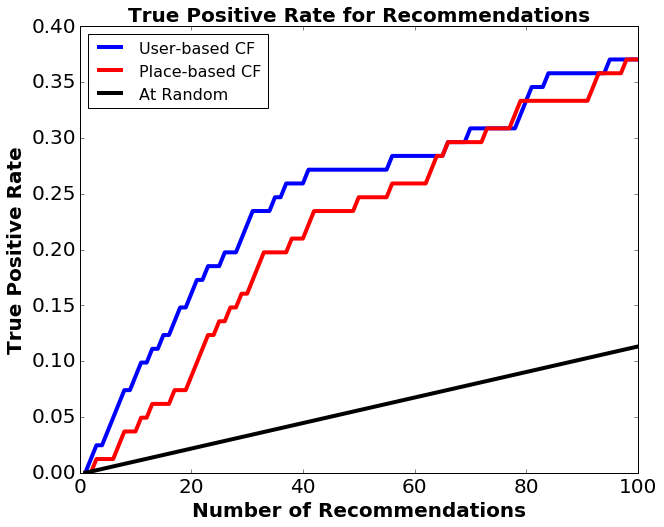

In [12]:
# Figure 1: True positive rates
f1 = plt.figure(figsize=(10, 8))
U_plot = plt.plot(list(range(1,num_rank+1)), true_pos_U, 'b', linewidth=4.0, label='User-based CF', )
I_plot = plt.plot(list(range(1,num_rank+1)), true_pos_I, 'r', linewidth=4.0, label='Place-based CF')
rand_plot = plt.plot(list(range(1,num_rank+1)), random_pos, 'k', linewidth=4.0, label='At Random')
plt.legend(loc='upper left',prop={'size':16});
plt.tick_params(labelsize=20)
plt.title('True Positive Rate for Recommendations', fontsize=20, fontweight='bold');
plt.ylabel('True Positive Rate', fontsize=20, fontweight='bold');
plt.xlabel('Number of Recommendations', fontsize=20, fontweight='bold');

## World Map
Maps are fun. The **red** dots are where the target user has already been. The **blue** dots are place-based recommendations in the top 100 that the target has not already been to. The **green** dots are user-based recommendations that are neither of the previous sets. Some obeservations (at *penalty=2.0*):
* Similar travellers go to the U.S. and E.U. -- the pattern is strong enough to overcome the popularity penalty
* Similar places tend to be in the developing world

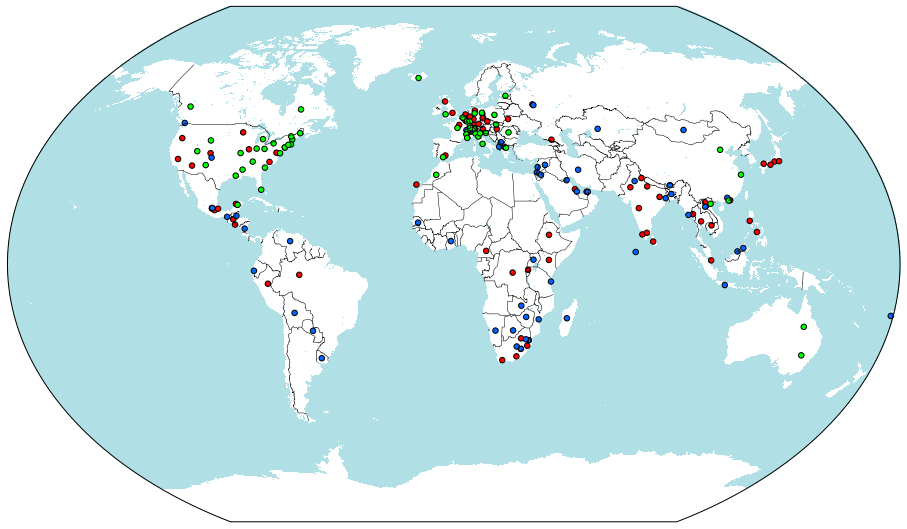

In [13]:
# Figure 2: World map of recommendations
f2 = plt.figure(figsize=(16, 100)) # limited by width, not height
world_map = Basemap(projection='kav7', resolution = 'i', area_thresh = 10000.0, lat_0=0, lon_0=0)
world_map.drawcountries();
world_map.drawlsmask(land_color='white',ocean_color='powderblue',lakes=True);

lats = [x[0] for x in coords_target if x is not None]
longs = [x[1] for x in coords_target if x is not None]
lat_set = set(lats); long_set = set(longs)
# Color and size of map markers
c_vals = [(1,0,0)]*len(lats); s_vals = [30]*len(lats)

# Add place-based recommendations to map
for i in range(num_rank):
    if coords_I[i]:
        if (coords_I[i][0] not in lat_set) and (coords_I[i][1] not in long_set):
            lats.append(coords_I[i][0])
            longs.append(coords_I[i][1])
            c_vals.append((0,0.4,1))
            s_vals.append(30)

# Add user-based recommendations to map
lat_set = set(lats); long_set = set(longs)
for i in range(num_rank):
    if coords_U[i]:
        if (coords_U[i][0] not in lat_set) and (coords_U[i][1] not in long_set):
            lats.append(coords_U[i][0])
            longs.append(coords_U[i][1])
            c_vals.append((0,1,0))
            s_vals.append(30)
            
x,y = world_map(longs, lats)
world_map.scatter(x, y, c=c_vals, s=s_vals);

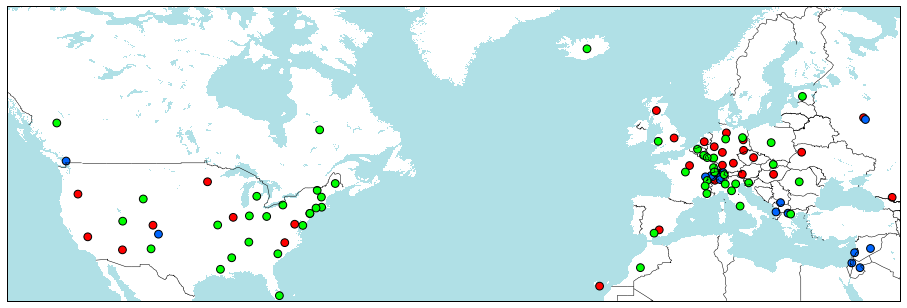

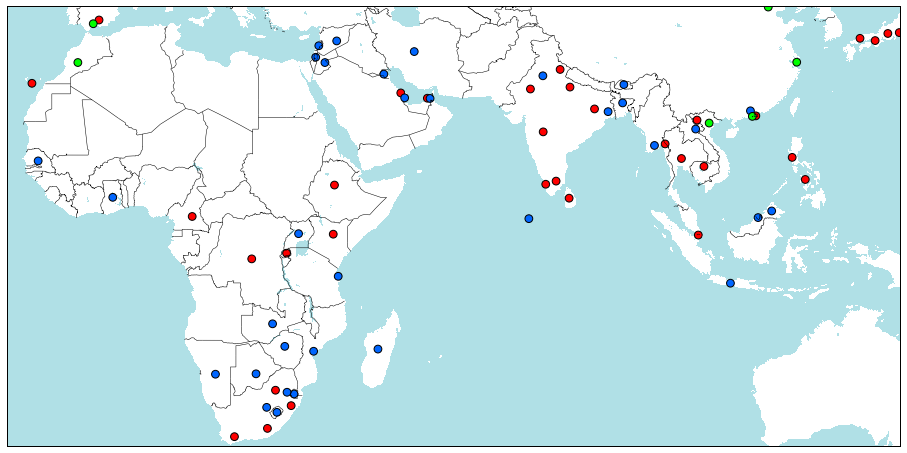

In [14]:
# Figures 3 & 4: Zoomed in on US-EU and Africa-Asia
f3 = plt.figure(figsize=(16, 100)) # limited by width, not height
us_eu_map = Basemap(projection='mill', resolution = 'i', area_thresh = 10000.0,
                    llcrnrlon = -135,              # lower-left corner longitude
                    llcrnrlat = 25,                # lower-left corner latitude
                    urcrnrlon = 45,                # upper-right corner longitude
                    urcrnrlat = 70,                # upper-right corner latitude
                    )
us_eu_map.drawcountries();
us_eu_map.drawlsmask(land_color='white',ocean_color='powderblue',lakes=True);
x,y = us_eu_map(longs, lats)
us_eu_map.scatter(x, y, c=c_vals, s=[2*x for x in s_vals]);

f4 = plt.figure(figsize=(16, 100)) # limited by width, not height
africa_asia_map = Basemap(projection='mill', resolution = 'i', area_thresh = 10000.0,
                    llcrnrlon = -20,               # lower-left corner longitude
                    llcrnrlat = -35,               # lower-left corner latitude
                    urcrnrlon = 140,               # upper-right corner longitude
                    urcrnrlat = 40,                # upper-right corner latitude
                    )
africa_asia_map.drawcountries();
africa_asia_map.drawlsmask(land_color='white',ocean_color='powderblue',lakes=True);
x,y = africa_asia_map(longs, lats)
africa_asia_map.scatter(x, y, c=c_vals, s=[2*x for x in s_vals]);